In [ ]:
import numpy as np

In [ ]:
m15=[1,2,3,4,5]
Mmax=[-17.3,-15.5,-15.6,-12.0,-10.1]
sigma=[0.7,0.7,0.7,0.7,0.7]

In [ ]:
def line(x,a,b):
  return a*x+b

In [ ]:
import scipy.optimize as op

In [ ]:
popt,pcov=op.curve_fit(line,m15,Mmax,sigma=sigma)
print(popt)

[  1.79       -19.46999999]


In [ ]:
import matplotlib.pyplot as plt

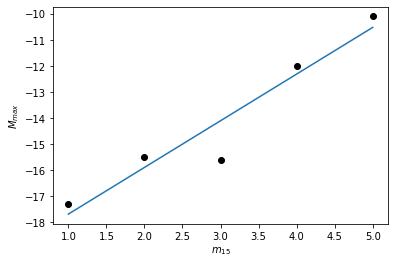

In [ ]:
plt.scatter(m15, Mmax, label = 'Line Data', c='k')
xx=np.array(m15)
plt.plot(xx,line(xx,*popt),label='fitted_line')
plt.xlabel("$m_{15}$")
plt.ylabel("$M_{max}$")
plt.show()

In [ ]:
import scipy.stats

In [ ]:
m15=[1,2,3,4,5]
Mmax=[-17.3,-15.5,-15.6,-12.0,-10.1]
a_init=1.79
b_init=-19.46999999
sigma_e = 0.7
x=np.array(m15)
y=np.array(Mmax)
yerr=[0.7,0.7,0.7,0.7,0.7]

slopes=(y[1:]-y[:-1])/(x[1:]-x[:-1])

a_mu,a_sigma=slopes.mean(), slopes.std()
b_mu=y.mean()-a_mu*x.mean()
b_sigma=np.sqrt(y.std()**2+(a_mu*x.std())**2+(x.mean()*a_sigma)**2)

print(a_mu,a_sigma,b_mu,b_sigma)

1.8000000000000003 1.3095800853708792 -19.5 5.374662780119325


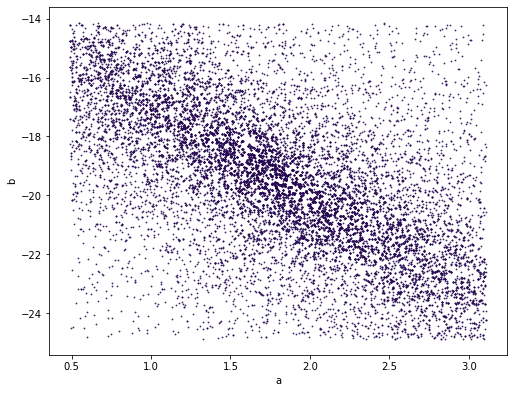

In [ ]:
steps=20000
sig=0.7
import seaborn as sns
sns.set_palette("inferno")

def mcmc_linreg(x,y,yerr):
  result=[[],[]]

  #sorting by x axis
  order=np.argsort(m15)
  x=np.array(m15)[order]
  y=np.array(Mmax)[order]

  #slopes
  slopes=(y[1:]-y[:-1])/(x[1:]-x[:-1])

  #guess range
  a_mu,a_sigma=slopes.mean(), slopes.std()
  b_mu=y.mean()-a_mu*x.mean()
  b_sigma=np.sqrt(y.std()**2+(a_mu*x.std())**2+(x.mean()*a_sigma)**2)

  #initial guess
  a_now=np.random.uniform(-a_sigma+a_mu,+a_sigma+a_mu)
  b_now=np.random.uniform(-b_sigma+b_mu,+b_sigma+b_mu)

  for i in range(int(steps)):
    result[0].append(a_now)
    result[1].append(b_now)

    a_next=np.random.uniform(-a_sigma+a_mu,+a_sigma+a_mu)
    b_next=np.random.uniform(-b_sigma+b_mu,+b_sigma+b_mu)

    y_now=a_now*x+b_now
    prob_now=np.sum((y-y_now)**2/sig)
    y_next=a_next*x+b_next
    prob_next=np.sum((y-y_next)**2/sig)

    r=min(prob_now/prob_next,1)
    if ~(np.random.uniform(0,1)>=r):
      a_now=a_next
      b_now=b_next

  result=np.array(result)
  burn_in=result[:,int(0*result[0].size):]
  return result

x=np.array(m15)
y=np.array(Mmax)
yerr=[0.7,0.7,0.7,0.7,0.7]

chain=mcmc_linreg(x,y,yerr)
a,b=chain

amax,bmax=np.abs(a).max(),np.abs(b).max()

x,y=np.linspace(-amax,amax,1000),np.linspace(-bmax,bmax,1000)

xv,yv=np.meshgrid(x,y)

def pdf(x,mu,sig):
  return np.exp((x-mu)**2/(2*sigma**2))

def fillgrid(x,y):
  return pdf(a,a.mean(),a.std())*pdf(b,b.mean(),b.std())

plt.figure(figsize=(8.2,6.4))

plt.scatter(a,b,s=0.7,alpha=0.8)
plt.xlabel("a")
plt.ylabel("b")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 's'
  **contour_kws,


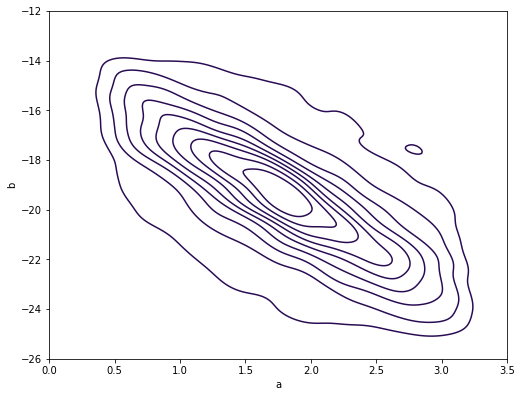

In [ ]:
import seaborn as sns
sns.set_palette("inferno")
plt.figure(figsize=(8.2,6.4))
sns.kdeplot(a, b, alpha=1.0, s=0.7)
plt.xlim(0.0, 3.5)
plt.ylim(-26, -12)
plt.xlabel("a")
plt.ylabel("b")
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import sklearn.datasets as datasets

np.random.seed(0)
tf.random.set_seed(0)

tfd = tfp.distributions #to get initial distribution
tfb = tfp.bijectors #bijectors for the flow

In [ ]:
ndim=2
zdist = tfd.MultivariateNormalDiag(loc=[0.0] * ndim)
zdist

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [ ]:
num_layers = 2
my_bijects = []

# loop over desired bijectors
for i in range(num_layers):
    # Making a Masked autoregressive flow
    anet = tfb.AutoregressiveNetwork(params=ndim, hidden_units=[500,500], activation="relu")

    ab = tfb.MaskedAutoregressiveFlow(anet)

    # Add the bijector "ab" to our list of bijectors

    my_bijects.append(ab)

    # Permutation
    permute = tfb.Permute([1, 0])
    my_bijects.append(permute)

# The big bijector is a chain of the other bijectors
big_bijector = tfb.Chain(my_bijects)

# transformed distribution
td = tfd.TransformedDistribution(zdist, bijector=big_bijector)

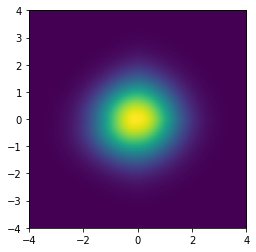

In [ ]:
#initial distribution --> 2D Gaussian

zpoints = np.linspace(-4, 4, 150)
(
    z1,
    z2,
) = np.meshgrid(zpoints, zpoints)

zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1, 1)), axis=1)
p = np.exp(td.log_prob(zgrid))
fig = plt.figure()
plt.imshow(p.reshape(z1.shape), aspect="equal", extent=[-4, 4, -4, 4])
plt.show()

In [ ]:
# dimension of x
x = tf.keras.Input(shape=(2,), dtype=tf.float32)

# placeholder for model output
log_prob = td.log_prob(x)

# making the model with input and output
model = tf.keras.Model(x, log_prob)

# -log likelihood for loss
def neg_loglik(yhat, log_prob):
    return -log_prob

# preparation for training
model.compile(optimizer=tf.optimizers.Adam(1e-3), loss=neg_loglik)

#early stopping callback to avoid over/underfitting
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

Epoch 1/100
625/625 [==============================] - 13s 18ms/step - loss: 5.1078 - val_loss: 3.4752
Epoch 2/100
625/625 [==============================] - 10s 16ms/step - loss: 3.4400 - val_loss: 3.2619
Epoch 3/100
625/625 [==============================] - 11s 18ms/step - loss: 3.0369 - val_loss: 2.8323
Epoch 4/100
625/625 [==============================] - 10s 16ms/step - loss: 2.8384 - val_loss: 2.8293
Epoch 5/100
625/625 [==============================] - 10s 16ms/step - loss: 2.8398 - val_loss: 2.8608
Epoch 6/100
625/625 [==============================] - 11s 17ms/step - loss: 2.8516 - val_loss: 2.8514
Epoch 7/100
625/625 [==============================] - 12s 19ms/step - loss: 2.8471 - val_loss: 2.8467
Epoch 8/100
625/625 [==============================] - 10s 16ms/step - loss: 2.8478 - val_loss: 2.8274
Epoch 9/100
625/625 [==============================] - 10s 16ms/step - loss: 2.8492 - val_loss: 2.8638
Epoch 10/100
625/625 [==============================] - 10s 16ms/step - l

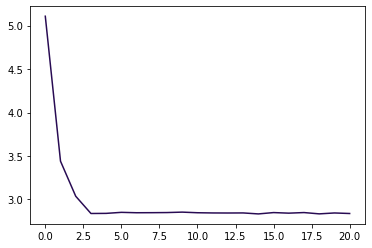

In [ ]:
#training the model

data=np.transpose(chain)
result = model.fit(x=data, y=np.zeros(steps), epochs=100, validation_data=(data,data), callbacks =[earlystopping])
plt.plot(result.history["loss"])
plt.show()

(20000, 2)


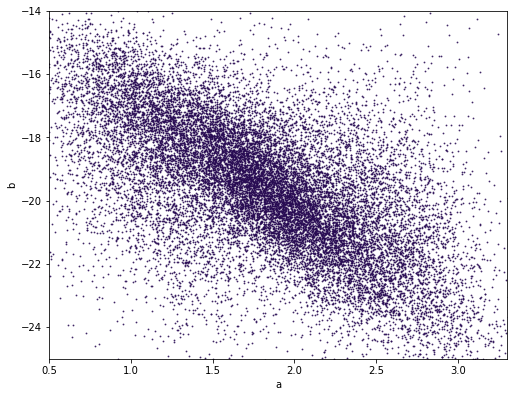

In [ ]:
#new fake points

zsamples = td.sample(steps)
print(zsamples.shape)
plt.figure(figsize=(8.2,6.4))
plt.scatter(zsamples[:, 0], zsamples[:, 1], alpha=0.8, s=0.7)
plt.xlim(0.5, 3.3)
plt.ylim(-25, -14)
plt.xlabel("a")
plt.ylabel("b")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 's'
  **contour_kws,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: The following kwargs were not used by contour: 's'
  **contour_kws,


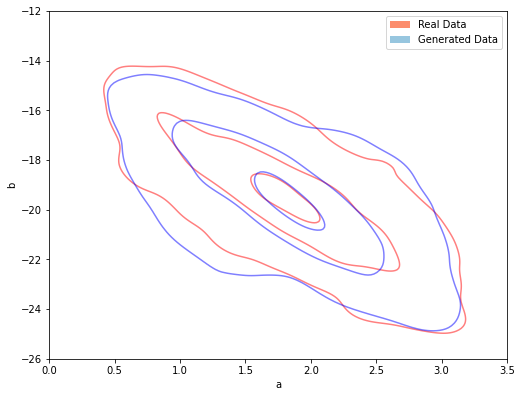

In [ ]:
#plotting the two distributions together

import seaborn as sns
import matplotlib.patches as  mpatches
a,b=chain
sns.set_palette("RdYlBu_r")
plt.figure(figsize=(8.2,6.4))
sns.kdeplot(a, b, alpha=0.5, s=0.7,color="red",levels=[0.1,0.5,0.9])
sns.kdeplot(zsamples[:, 0], zsamples[:, 1], alpha=0.5, s=0.7,color="blue",levels=[0.1,0.5,0.9])
plt.xlim(0.0, 3.5)
plt.ylim(-26, -12)
plt.xlabel("a")
plt.ylabel("b")
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Real Data"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="Generated Data")]
plt.legend(handles=handles)
plt.show()

In [ ]:
from scipy.stats import gaussian_kde as gkde

print(chain.shape)
zsamples=np.transpose(zsamples)
print(zsamples.shape)

a,b=chain
xp,yp=zsamples

kde1=gkde(chain)
kde2=gkde(zsamples)

dat1=kde1.evaluate(chain)
dat2=kde2.evaluate(zsamples)

print(dat1.shape,dat2.shape)

(2, 20000)
(2, 20000)
(20000,) (20000,)


In [ ]:
#defining the KL divergence
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

print(KL(dat1/np.sum(dat1),dat2/np.sum(dat2)))

0.6077276499724721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [ ]:
from scipy.stats import ks_2samp

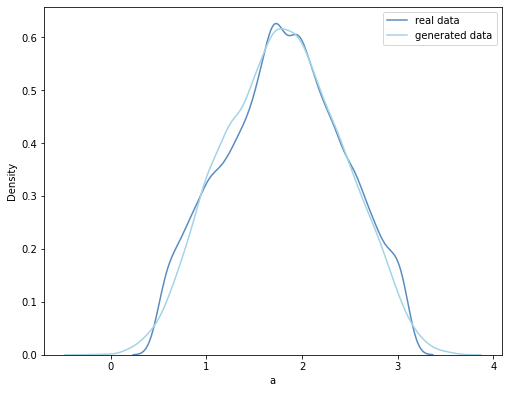

In [ ]:
#KS test for a

a,b=chain
xp,yp=zsamples

kdea=gkde(a)
kdexp=gkde(xp)

pa=kdea.evaluate(a)
pxp=kdexp.evaluate(xp)

ks_2samp(a,xp,alternative="two-faced")

plt.figure(figsize=(8.2,6.4))
sns.kdeplot(a,label="real data")
sns.kdeplot(xp,label="generated data")
plt.xlabel("a")
plt.legend()
plt.show()

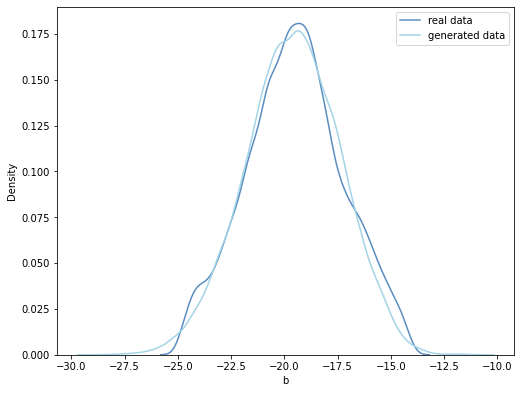

In [ ]:
#KS test for b

kdeb=gkde(b)
kdeyp=gkde(yp)

pb=kdeb.evaluate(b)
pyp=kdeyp.evaluate(yp)

ks_2samp(b,yp,alternative="two-faced")

plt.figure(figsize=(8.2,6.4))
sns.kdeplot(b,label="real data")
sns.kdeplot(yp,label="generated data")
plt.xlabel("b")
plt.legend()
plt.show()

In [ ]:
#discarded -- joint distribution
#ks_2samp(dat1,dat2,alternative="two-faced")

In [ ]:
#KL for a and b

print(KL(pa/np.sum(pa),pxp/np.sum(pxp)))
print(KL(pb/np.sum(pb),pyp/np.sum(pyp)))

0.16714630333702635
0.2336988178929657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<Figure size 590.4x460.8 with 0 Axes>

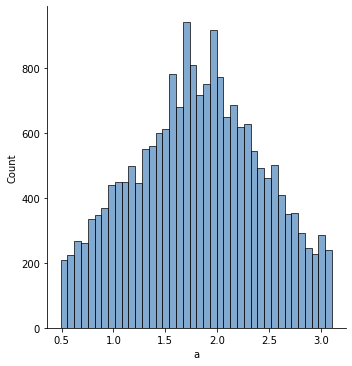

In [ ]:
plt.figure(figsize=(8.2,6.4))
sns.displot(a)
plt.xlabel("a")
plt.show()

<Figure size 590.4x460.8 with 0 Axes>

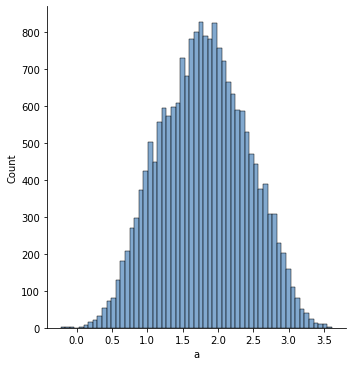

In [ ]:
plt.figure(figsize=(8.2,6.4))
sns.displot(xp)
plt.xlabel("a")
plt.show()

<Figure size 590.4x460.8 with 0 Axes>

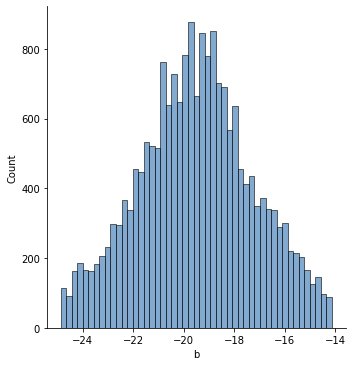

In [ ]:
plt.figure(figsize=(8.2,6.4))
sns.displot(b)
plt.xlabel("b")
plt.show()

<Figure size 590.4x460.8 with 0 Axes>

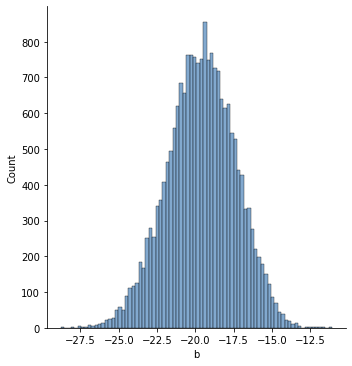

In [ ]:
plt.figure(figsize=(8.2,6.4))
sns.displot(yp)
plt.xlabel("b")
plt.show()